In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [6]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print('======> torch.cuda is avilable!\n', 'device:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('======> torch.cuda is not working ...\n', 'device:', device)

======> torch.cuda is avilable!
 device: NVIDIA GeForce GTX 1660


# Read  a batch of training images along with their bounding boxes and labels
In this example, use read only 1 image, i.e. batch_size = 1

In [7]:
# input image could be of any size
img0 = cv2.imread('../datasets/S_kaggle_wildfire/000001.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

(540, 960, 3)


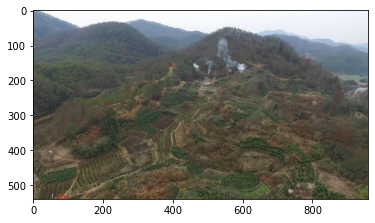

In [8]:
print(img0.shape)
plt.imshow(img0)
plt.show()

In [25]:
# Object information a set bounding boxes [ymin, xmin, ymax, xmax] and their labels
bbox0 = np.array([[50, 450, 200, 610], [120, 410, 160, 510]])
labels = np.array(['smoke', 'smoke']) # 0: background, 1: smoke

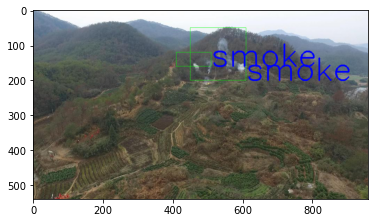

In [26]:
# display bounding box and labels
# cv2.putText(影像， 文字， 坐标， 字形， 大小， 颜色， 线条宽度， 线条种类)
img0_clone= np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color = (0, 255, 0), thickness = 1)
    cv2.putText(img0_clone, str(str(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness = 3)

plt.imshow(img0_clone)
plt.show()

# Resize the input images to (h = 800, w = 800)

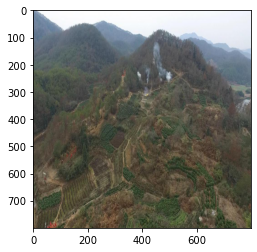

In [27]:
img = cv2.resize(img0, dsize = (800, 800), interpolation = cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [28]:
# change the bounding box coordinate
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[ 74 375 296 508]
 [177 341 237 425]]


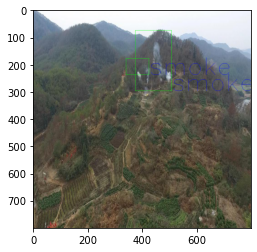

In [30]:
# dispaly bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    # draw rectangle
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color = (0, 255, 0), thickness = 1)

    # write the prediction label
    cv2.putText(img_clone, str(str(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness = 1)

plt.imshow(img_clone)
plt.show()

# USe VGG16 to extract features from input images
Input images (batch_size, H = 800, W = 800, d = 3);  
Features (batch_size, H = 50, W = 50, d = 512)

In [32]:
# list all the layers of VGG16
model = torchvision.models.vgg16(pretrained = True).to(device)
fe = list(model.features)
print(len(fe))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/qiao/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

31


In [ ]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800]
# test image array [1, 3, 800. 800 ]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features))
print(out_channels)
